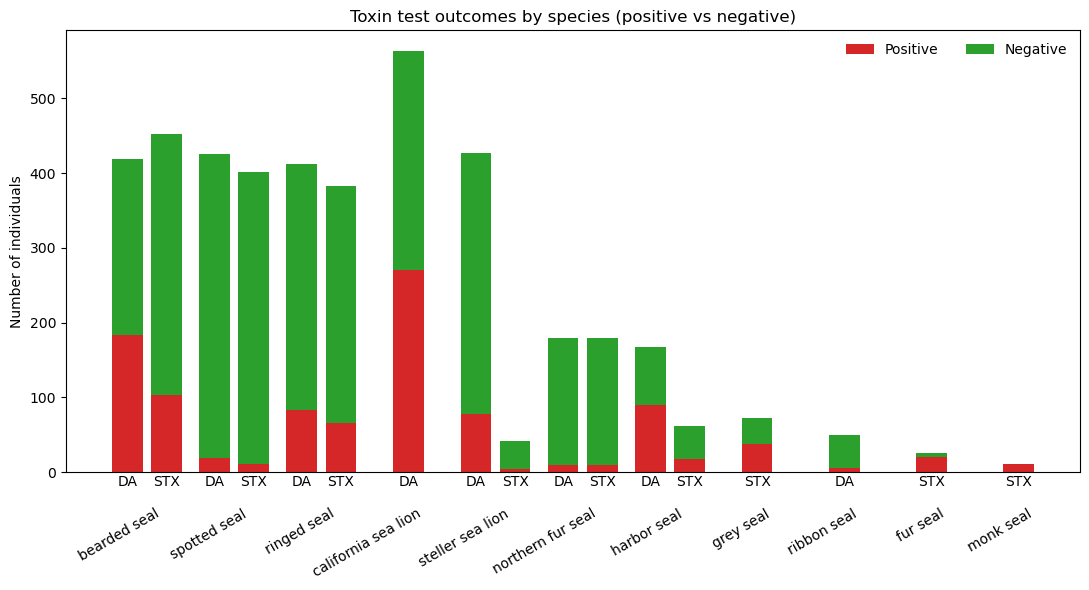

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
df = pd.read_csv("../data/processed/final_meta_table.csv")

# --- Coerce numeric & clean ---
for col in ["n", "n_total"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["toxin", "species", "n", "n_total"]).copy()
df["n"] = np.where(df["n"] > df["n_total"], df["n_total"], df["n"])

# --- Aggregate replicates per species × toxin ---
agg = (
    df.groupby(["species", "toxin"], as_index=False)
      .agg(n=("n", "sum"), n_total=("n_total", "sum"))
)
agg["negative"] = agg["n_total"] - agg["n"]

# --- Sort species by total samples (descending) ---
species_totals = agg.groupby("species")["n_total"].sum().sort_values(ascending=False)
species_order = species_totals.index.tolist()

# toxin order preference; fall back to whatever is present
tox_order_pref = ["DA", "STX"]
present = agg["toxin"].unique().tolist()
tox_present = [t for t in tox_order_pref if t in present] or sorted(present)

# --- Geometry: positions for grouped bars ---
width = 0.35
gap   = 0.10
group_centers = np.arange(len(species_order))

bar_specs = []   # (x, sp, tox, pos, neg)
minor_ticks, minor_labels = [], []

for i, sp in enumerate(species_order):
    sub = agg[agg["species"] == sp]
    toks_here = [t for t in tox_present if t in set(sub["toxin"])]
    if not toks_here:
        continue
    k = len(toks_here)
    total_w = k*width + (k-1)*gap
    start = group_centers[i] - total_w/2.0
    for j, tox in enumerate(toks_here):
        x = start + j*(width+gap)
        row = sub[sub["toxin"] == tox].iloc[0]
        bar_specs.append((x, sp, tox, row["n"], row["negative"]))
        minor_ticks.append(x)
        minor_labels.append(tox)

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 6))

colors = {"positive": "#d62728", "negative": "#2ca02c"}
first_pos, first_neg = True, True

for x, sp, tox, pos_cnt, neg_cnt in bar_specs:
    ax.bar(x, pos_cnt, width=width, color=colors["positive"],
           label="Positive" if first_pos else None)
    ax.bar(x, neg_cnt, width=width, bottom=pos_cnt, color=colors["negative"],
           label="Negative" if first_neg else None)
    first_pos = False
    first_neg = False

# --- X axis with two label rows ---
ax.set_xticks(group_centers)
ax.set_xticklabels(species_order)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(minor_labels, minor=True)

# Tilt species labels (major ticks)
ax.tick_params(axis="x", which="major", pad=25, length=0)
for lbl in ax.get_xticklabels(which="major"):
    lbl.set_rotation(30)
    lbl.set_ha("right")

# Keep toxin labels horizontal
ax.tick_params(axis="x", which="minor", pad=2, length=0)

# --- Aesthetics ---
ax.set_ylabel("Number of individuals")
ax.set_title("Toxin test outcomes by species (positive vs negative)")
ax.legend(frameon=False, ncol=2, loc="upper right")
ax.margins(x=0.05)

plt.tight_layout()
plt.show()


In [ ]:
# --- Summary statistics ---
import numpy as np
import pandas as pd

# minimal guard
if "df" not in globals():
    raise RuntimeError("Run Cell 1 first to create the cleaned DataFrame 'df'.")

# 1) Most tested species
species_totals = df.groupby("species", dropna=False)["n_total"].sum().sort_values(ascending=False)

# 2) Per-toxin totals & proportions
toxin_stats = (
    df.groupby("toxin", dropna=False)
      .agg(total_tested=("n_total", "sum"),
           total_positive=("n", "sum"))
      .assign(
          total_negative=lambda x: x["total_tested"] - x["total_positive"],
          positive_rate=lambda x: x["total_positive"] / x["total_tested"]
      )
)

# 3) Overall totals
tested_sum   = int(df["n_total"].sum())
positive_sum = int(df["n"].sum())
overall = {
    "total_tested": tested_sum,
    "total_positive": positive_sum,
    "total_negative": int(tested_sum - positive_sum),
    "overall_positive_rate": float(positive_sum / tested_sum) if tested_sum else np.nan
}


print("=== Most Tested Species ===")
print(species_totals.to_string(), "\n")

print("=== Toxin Statistics ===")
print(toxin_stats.to_string(formatters={"positive_rate": "{:.2%}".format}), "\n")

print("=== Overall Totals ===")
print(overall)


=== Most Tested Species ===
species
bearded seal           872
spotted seal           828
ringed seal            795
california sea lion    563
steller sea lion       469
northern fur seal      358
harbor seal            229
grey seal               72
ribbon seal             49
fur seal                25
monk seal               11 

=== Toxin Statistics ===
       total_tested  total_positive  total_negative positive_rate
toxin                                                            
DA             2642           738.0          1904.0        27.93%
STX            1629           277.0          1352.0        17.00% 

=== Overall Totals ===
{'total_tested': 4271, 'total_positive': 1015, 'total_negative': 3256, 'overall_positive_rate': 0.23764926246780613}
